# ManTra-Net: Manipulation Tracing Network For Detection and Localization of Image Forgeries With Anomalous Features

## This is a simple demonstrative notebook for the pretrained ManTra-Net

## Note:

- Please make sure you run this notebook with the GPU support. You may see tensorflow errors when decoding images of very large sizes, e.g. 2048x3072.
- All lib/data paths used in this notebook is relative. In case you run this notebook outside of its original location, please fix the data paths.

# 1. Download the ManTraNet Repo

In [1]:
!pip install tensorflow==1.14

     |████████████████████████████████| 109.3MB 38kB/s 
     |████████████████████████████████| 3.2MB 43.5MB/s 
     |████████████████████████████████| 491kB 57.5MB/s 
     |████████████████████████████████| 51kB 9.2MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [2]:
!rm -rf ManTraNet
!git clone https://github.com/ISICV/ManTraNet.git


Cloning into 'ManTraNet'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 211 (delta 4), reused 1 (delta 0), pack-reused 202
Receiving objects: 100% (211/211), 140.00 MiB | 43.56 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [3]:
pip install keras==2.2.4

     |████████████████████████████████| 317kB 21.7MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


# 2. Import Dependent Libs and Set Paths

In [4]:
import os
import numpy as np 
import cv2
import requests
import sys

from PIL import Image
from io import BytesIO
from matplotlib import pyplot


In [5]:
manTraNet_root = '/content/ManTraNet'
manTraNet_srcDir = os.path.join( manTraNet_root, 'src' )
sys.path.insert( 0, manTraNet_srcDir )
manTraNet_modelDir = os.path.join( manTraNet_root, 'pretrained_weights' )

# 3. Load Sample Data 

In [6]:
manTraNet_dataDir = os.path.join( manTraNet_root, 'data' )
sample_file = os.path.join( manTraNet_dataDir, 'samplePairs.csv' )
assert os.path.isfile( sample_file ), "ERROR: can NOT find sample data, check `manTraNet_root`"
with open( sample_file ) as IN :
    sample_pairs = [line.strip().split(',') for line in IN.readlines() ]
L = len(sample_pairs)
print("INFO: in total, load", L, "samples")
    
def get_a_random_pair() :
    idx = np.random.randint(0,L)
    return ( os.path.join( manTraNet_dataDir, this ) for this in sample_pairs[idx] ) 

INFO: in total, load 72 samples


# 4. Load A Pretrained ManTraNet Model

In [7]:
import modelCore
manTraNet = modelCore.load_pretrain_model_by_index( 4, manTraNet_modelDir )

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

/usr/local/lib/python3.7/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

INFO: use activation in the last CONV=None
INFO: unfreeze feature extraction part, trainable=True






In [8]:
# ManTraNet Architecture 
print(manTraNet.summary(line_length=120))

________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
img_in (InputLayer)                    (None, None, None, 3)      0                                                     
________________________________________________________________________________________________________________________
Featex (Model)                         (None, None, None, 256)    3675181       img_in[0][0]                            
________________________________________________________________________________________________________________________
outlierTrans (Conv2D)                  (None, None, None, 64)     16384         Featex[1][0]                            
________________________________________________________________________________________________________________________
bnorm (BatchNormalization)      

In [9]:
manTraNet.layers[1].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_in (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
b1c1 (CombinedConv2D)        (None, None, None, 16)    525       
_________________________________________________________________
b1c2 (Conv2DSymPadding)      (None, None, None, 32)    4640      
_________________________________________________________________
b2c1 (Conv2DSymPadding)      (None, None, None, 64)    18496     
_________________________________________________________________
b2c2 (Conv2DSymPadding)      (None, None, None, 64)    36928     
_________________________________________________________________
b3c1 (Conv2DSymPadding)      (None, None, None, 128)   73856     
_________________________________________________________________
b3c2 (Conv2DSymPadding)      (None, None, None, 128)   147584    
__________

In [10]:
# Image Manipulation Classification Network
IMCFeatex = manTraNet.get_layer('Featex')
print(IMCFeatex.summary(line_length=120))

________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
image_in (InputLayer)                                 (None, None, None, 3)                           0                 
________________________________________________________________________________________________________________________
b1c1 (CombinedConv2D)                                 (None, None, None, 16)                          525               
________________________________________________________________________________________________________________________
b1c2 (Conv2DSymPadding)                               (None, None, None, 32)                          4640              
________________________________________________________________________________________________________________________
b2c1 (Conv2DSymPadding)         

# 5. Play With The Provided Sample Data

## Note: we don't need original image files for forgery detection. They are included here to demonstrate the effectiveness of the ManTra-Net.


In [11]:
from datetime import datetime 
def read_rgb_image( image_file ) :
    rgb = cv2.imread( image_file, 1 )[...,::-1]
    return rgb
    
def decode_an_image_array( rgb, manTraNet, dn=1 ) :
    x = np.expand_dims( rgb.astype('float32')/255.*2-1, axis=0 )[:,::dn,::dn]
    t0 = datetime.now()
    y = manTraNet.predict(x)[0,...,0]
    t1 = datetime.now()
    return y, t1-t0

def decode_an_image_file( image_file, manTraNet, dn=1 ) :
    rgb = read_rgb_image( image_file )
    mask, ptime = decode_an_image_array( rgb, manTraNet, dn )
    return rgb[::dn,::dn], mask, ptime.total_seconds()

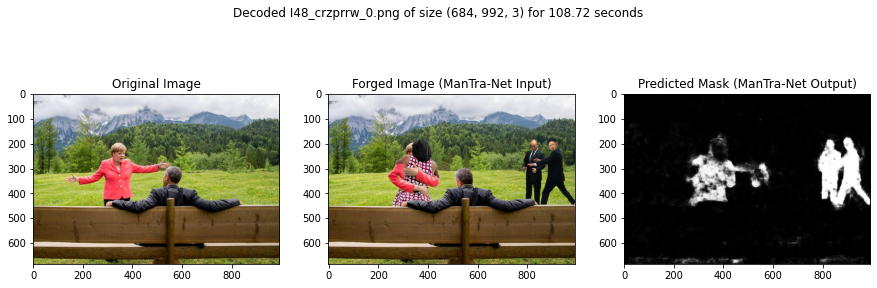

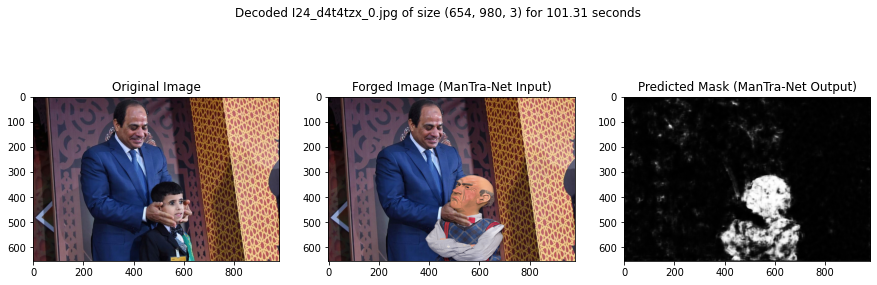

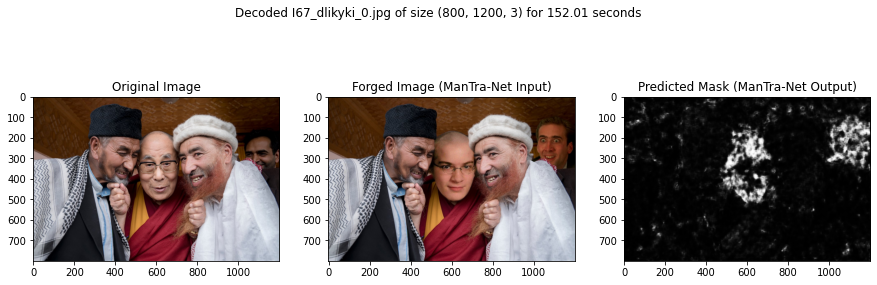

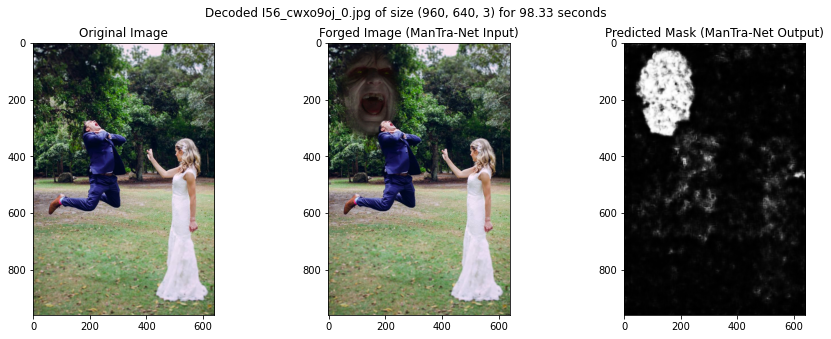

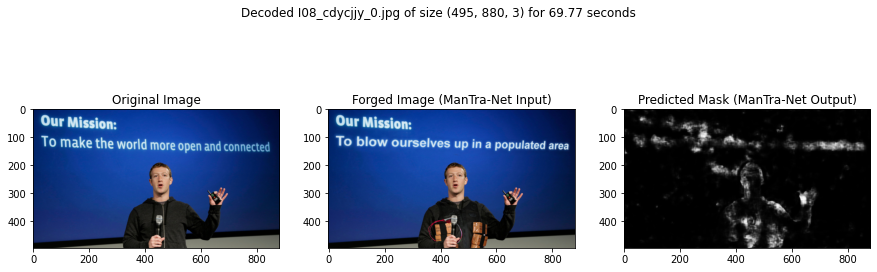

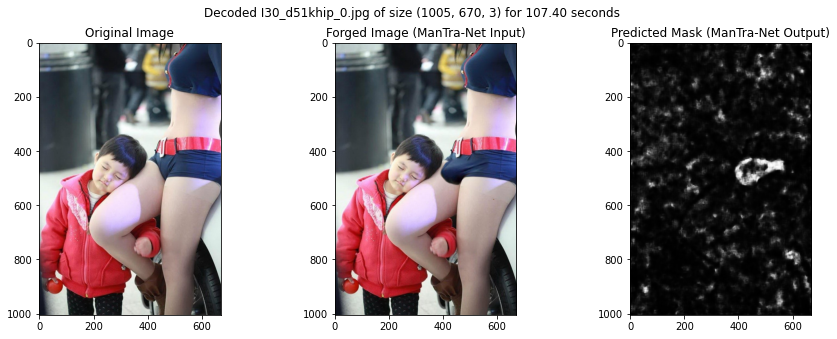

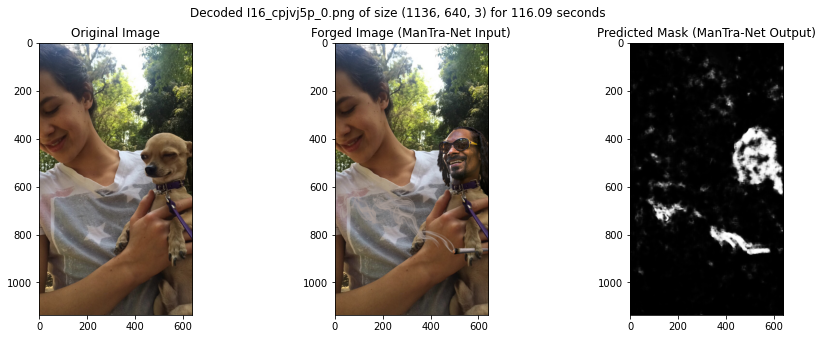

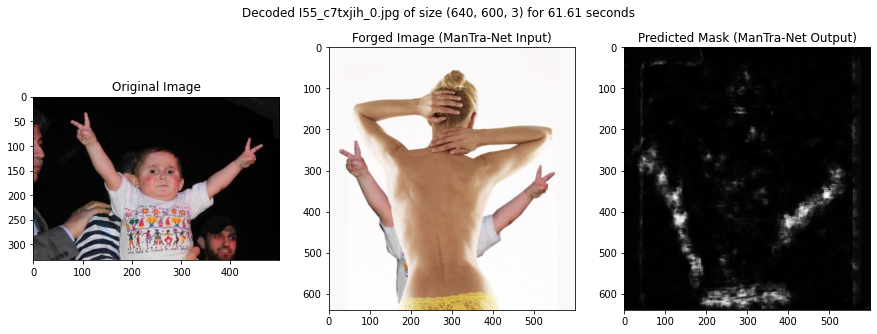

In [12]:
for k in range(8) :
    # get a sample
    forged_file, original_file = get_a_random_pair()
    # load the original image just for reference
    ori = read_rgb_image( original_file )
    # manipulation detection using ManTraNet
    rgb, mask, ptime = decode_an_image_file( forged_file, manTraNet ) 
    # show results
    pyplot.figure( figsize=(15,5) )
    pyplot.subplot(131)
    pyplot.imshow( ori )
    pyplot.title('Original Image')
    pyplot.subplot(132)
    pyplot.imshow( rgb )
    pyplot.title('Forged Image (ManTra-Net Input)')
    pyplot.subplot(133)
    pyplot.imshow( mask, cmap='gray' )
    pyplot.title('Predicted Mask (ManTra-Net Output)')
    pyplot.suptitle('Decoded {} of size {} for {:.2f} seconds'.format( os.path.basename( forged_file ), rgb.shape, ptime ) )
    pyplot.show()

# 6. Play with Internet Data

### Note: Internet images are often compressed and/or resized, and this means subtle manipulations will be much more difficult to detect after such postprocessing. 

### Therefore, don't be surprised if you see ManTraNet fails on some sample. 


In [13]:
def get_image_from_url(url, xrange=None, yrange=None, dn=1) :
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = np.array(img)
    if img.shape[-1] > 3 :
        img = img[...,:3]
    ori = np.array(img)
    if xrange is not None :
        img = img[:,xrange[0]:xrange[1]]
    if yrange is not None :
        img = img[yrange[0]:yrange[1]]
    mask, ptime =  decode_an_image_array( img, manTraNet, dn )
    ptime = ptime.total_seconds()
    # show results
    pyplot.figure( figsize=(15,5) )
    pyplot.title('Original Image')
    pyplot.subplot(131)
    pyplot.imshow( img )
    pyplot.title('Forged Image (ManTra-Net Input)')
    pyplot.subplot(132)
    pyplot.imshow( mask, cmap='gray' )
    pyplot.title('Predicted Mask (ManTra-Net Output)')
    pyplot.subplot(133)
    pyplot.imshow( np.round(np.expand_dims(mask,axis=-1) * img[::dn,::dn]).astype('uint8'), cmap='jet' )
    pyplot.title('Highlighted Forged Regions')
    pyplot.suptitle('Decoded {} of size {} for {:.2f} seconds'.format( url, rgb.shape, ptime ) )
    pyplot.show()
    

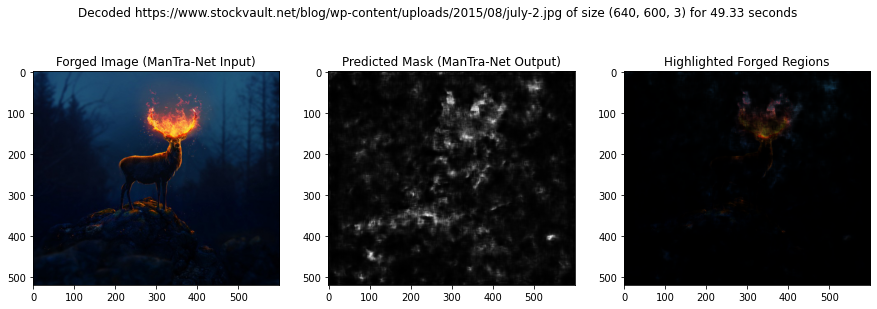

In [14]:
get_image_from_url('https://www.stockvault.net/blog/wp-content/uploads/2015/08/july-2.jpg')

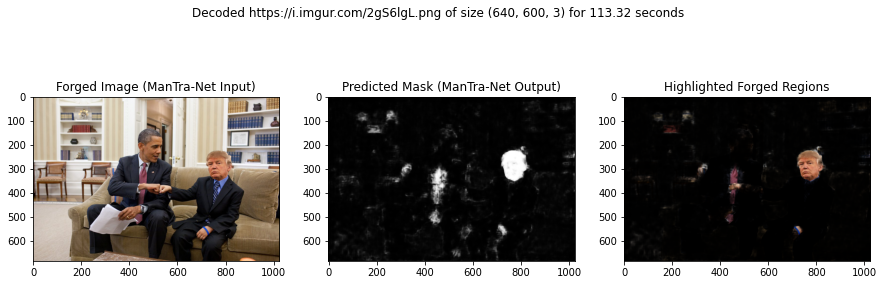

In [15]:
 get_image_from_url('https://i.imgur.com/2gS6lgL.png')

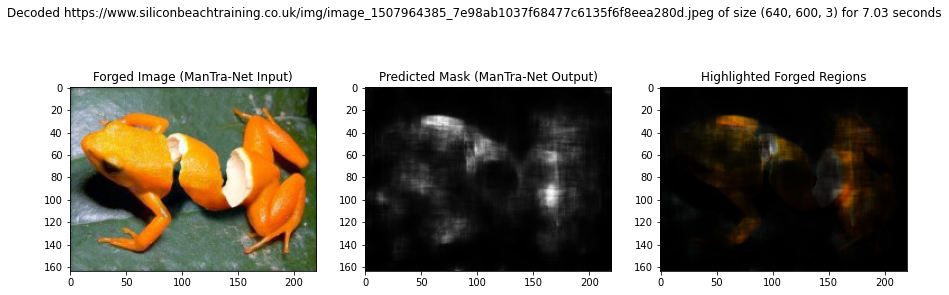

In [16]:
get_image_from_url('https://www.siliconbeachtraining.co.uk/img/image_1507964385_7e98ab1037f68477c6135f6f8eea280d.jpeg')

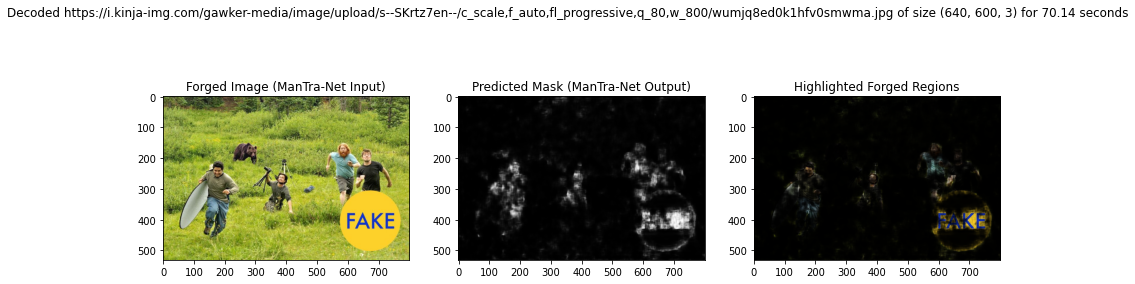

In [17]:
get_image_from_url('https://i.kinja-img.com/gawker-media/image/upload/s--SKrtz7en--/c_scale,f_auto,fl_progressive,q_80,w_800/wumjq8ed0k1hfv0smwma.jpg')